# Dataset Extraction

In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/dataset/absT.zip'
extract_dir = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset extracted to:", extract_dir)

Mounted at /content/drive
Dataset extracted to: /content


# Imports and Configuration

In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
from itertools import cycle

# Config
IMG_WIDTH = 96
IMG_HEIGHT = 598
NUM_CLASSES = 7
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.0001

DATASET_DIR = '/content/absT'
TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, 'train/images')
TRAIN_LABEL_DIR = os.path.join(DATASET_DIR, 'train/labels')
VALID_IMAGE_DIR = os.path.join(DATASET_DIR, 'valid/images')
VALID_LABEL_DIR = os.path.join(DATASET_DIR, 'valid/labels')

# Save and output directories
MODEL_SAVE_PATH = '/content/drive/MyDrive/model'
OUTPUT_DIR = '/content/drive/MyDrive/output'

os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


# Data Preparation Functions

In [ ]:
def parse_yolo_annotation(txt_path):
    with open(txt_path, 'r') as f:
        line = f.readline().strip()
        if line == "":
            return None, None
        parts = line.split()
        class_id = int(parts[0])
        bbox = np.array([float(x) for x in parts[1:5]], dtype=np.float32)
        return bbox, class_id

def load_image_and_label(image_path, label_dir):
    image_path = image_path.numpy().decode('utf-8')
    label_dir = label_dir.numpy().decode('utf-8')

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w = image.shape[:2]
    scale = min(IMG_WIDTH / w, IMG_HEIGHT / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized_image = cv2.resize(image, (new_w, new_h))

    pad_w = (IMG_WIDTH - new_w) // 2
    pad_h = (IMG_HEIGHT - new_h) // 2
    padded_image = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
    padded_image[pad_h:pad_h + new_h, pad_w:pad_w + new_w, :] = resized_image
    padded_image = padded_image / 255.0

    base = os.path.splitext(os.path.basename(image_path))[0]
    txt_path = os.path.join(label_dir, base + ".txt")
    bbox, class_id = parse_yolo_annotation(txt_path)

    if bbox is None or class_id is None:
        raise ValueError(f"No valid annotation found for image: {image_path}")

    x_center, y_center, width, height = bbox
    x_center = x_center * new_w + pad_w
    y_center = y_center * new_h + pad_h
    width = width * new_w
    height = height * new_h
    adjusted_bbox = [x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

    class_one_hot = np.zeros(NUM_CLASSES, dtype=np.float32)
    class_one_hot[class_id] = 1.0

    return padded_image, adjusted_bbox, class_one_hot

def tf_load_image_and_label(image_path, label_dir):
    image, bbox, class_one_hot = tf.py_function(
        func=load_image_and_label,
        inp=[image_path, label_dir],
        Tout=[tf.float32, tf.float32, tf.float32]
    )
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    bbox.set_shape([4])
    class_one_hot.set_shape([NUM_CLASSES])
    return image, {'bbox_output': bbox, 'class_output': class_one_hot}

# Dataset Loading

In [ ]:
train_image_paths = glob.glob(os.path.join(TRAIN_IMAGE_DIR, "*.png"))
valid_image_paths = glob.glob(os.path.join(VALID_IMAGE_DIR, "*.png"))
print(f"Found {len(train_image_paths)} training images.")
print(f"Found {len(valid_image_paths)} validation images.")

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, [TRAIN_LABEL_DIR] * len(train_image_paths)))
train_dataset = train_dataset.map(tf_load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_image_paths, [VALID_LABEL_DIR] * len(valid_image_paths)))
valid_dataset = valid_dataset.map(tf_load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Found 1921 training images.
Found 411 validation images.


# Model Building and Compilation

In [ ]:
def build_cnn_model():
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = inputs
    for filters in [32, 64, 128, 256, 512]:
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = LeakyReLU(negative_slope=0.1)(x)
        x = BatchNormalization()(x)
        x = MaxPool2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)
    class_output = Dense(NUM_CLASSES, activation='softmax', name='class_output')(x)

    return Model(inputs=inputs, outputs={'bbox_output': bbox_output, 'class_output': class_output})

model = build_cnn_model()
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss={'bbox_output': 'mse', 'class_output': CategoricalCrossentropy()},
    metrics={'class_output': 'accuracy'}
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 598, 96,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 598, 96,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 598, 96,   │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 598, 96,   │        128 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 299, 48,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 299, 48,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 299, 48,   │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 299, 48,   │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 149, 24,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 149, 24,   │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 149, 24,   │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 24,   │        512 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 74, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 74, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 74, 12,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 12,    │      1,024 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 37, 6,     │          0 │ batch_normalizat

 Total params: 15,734,475 (60.02 MB)

 Trainable params: 15,732,491 (60.01 MB)

 Non-trainable params: 1,984 (7.75 KB)

# Model Training

In [ ]:
start_time = time.time()

def lr_scheduler(epoch):
    if epoch < 10:
        return LEARNING_RATE
    return LEARNING_RATE * tf.math.exp(-0.1 * (epoch - 10)).numpy()

callbacks = [
    ModelCheckpoint(os.path.join(MODEL_SAVE_PATH, 'cnn_mpfp3.keras'),
                    monitor='val_class_output_accuracy',
                    save_best_only=True,
                    mode='max',
                    verbose=1),
    EarlyStopping(monitor='val_class_output_accuracy',
                  patience=10,
                  mode='max',
                  verbose=1),
    LearningRateScheduler(lr_scheduler)
]

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
elapsed = end_time - start_time
print(f"Model training time: {elapsed / 60:.2f} minutes")

Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - bbox_output_loss: 0.1247 - class_output_accuracy: 0.5317 - class_output_loss: 2.7924 - loss: 2.9171
Epoch 1: val_class_output_accuracy improved from -inf to 0.29197, saving model to /content/drive/MyDrive/model/cnn_mpfp3.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 57s 171ms/step - bbox_output_loss: 0.1246 - class_output_accuracy: 0.5320 - class_output_loss: 2.7888 - loss: 2.9134 - val_bbox_output_loss: 0.0508 - val_class_output_accuracy: 0.2920 - val_class_output_loss: 16.8512 - val_loss: 16.8639 - learning_rate: 1.0000e-04
Epoch 2/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - bbox_output_loss: 0.0758 - class_output_accuracy: 0.7441 - class_output_loss: 0.7039 - loss: 0.7797
Epoch 2: val_class_output_accuracy improved from 0.29197 to 0.32360, saving model to /content/drive/MyDrive/model/cnn_mpfp3.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - bbox_output_loss: 0.0758 - class_output_accuracy: 0.7442 - class_output_loss: 0.7036 - loss: 

# Training Metrics Visualization

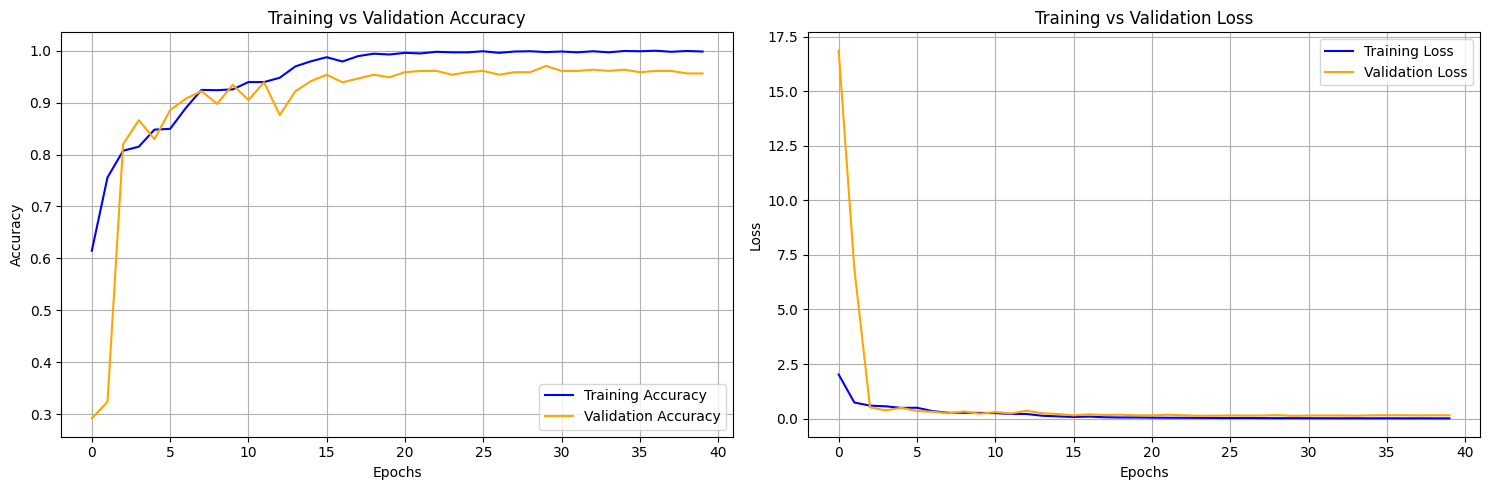

Final Model Accuracy Report
Training Accuracy:   99.84%
Validation Accuracy: 95.62%


In [ ]:
plt.figure(figsize=(15, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'cnn_training_metrics.png'))
plt.show()

# Final Accuracy Summary
final_train_acc = history.history['class_output_accuracy'][-1] * 100
final_val_acc = history.history['val_class_output_accuracy'][-1] * 100
print("Final Model Accuracy Report")
print(f"Training Accuracy:   {final_train_acc:.2f}%")
print(f"Validation Accuracy: {final_val_acc:.2f}%")

# Model Saving

In [ ]:
# Cell 8
final_model_path = os.path.join(MODEL_SAVE_PATH, 'cnn3_model.keras')
model.save(final_model_path)
print(f"Final model saved to: {final_model_path}")
print(f"Total training time (recalled): {elapsed / 60:.2f} minutes")

Final model saved to: /content/drive/MyDrive/model/cnn3_model.keras
Total training time (recalled): 12.96 minutes
